In [1]:
from algorithm import *
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.optimize import minimize

In [2]:
def get_nu_star(xi, params):

    def objective(nu):

        if xi(nu, **params)>0:
            return -(np.log(xi(nu, **params)) - 0.5*np.dot(nu.T, nu))
        else:
            return 1e80
        
    nu0 = np.zeros(params["d"])

    result = minimize(objective, nu0, method='SLSQP')

    if result.success:
        return result.x/np.linalg.norm(result.x)
    else:
        raise ValueError("L'optimisation n'a pas réussi à converger.")

# Asian Option

In [41]:
def asian_function(y, S0, v, mu, maturity, strike, rate, d):

    k = np.arange(1, d + 1)
    y_cum = np.cumsum(y)
    payoff = np.exp(-rate*maturity)*max(S0*np.sum(np.exp(mu*(k*maturity)/d + v*np.sqrt(maturity/d)*y_cum))/d - strike, 0)

    return payoff

In [46]:
d = 16
T = 1
r = 0.02
S0 = 50
K = 40
v = 0.1

params_asian = {
    "d": d,
    "S0": S0,
    "v": v,
    "mu": r-0.5*v**2,
    "maturity": T,
    "strike": K,
    "rate": r
}

In [47]:
I = 100
M = 20000
mean = np.zeros(d)
cov = np.eye(d)

drift_vector_asian = get_nu_star(asian_function, params_asian)


phi_asian = lambda y: np.exp(- drift_vector_asian.T @ y - 0.5*drift_vector_asian.T @ drift_vector_asian)*asian_function(y + drift_vector_asian, params_asian['S0'], params_asian['v'], params_asian['mu'], params_asian['maturity'], params_asian['strike'], params_asian['rate'], params_asian['d'])

In [48]:
algo_asian = Algorithm(M,
                 I,
                 d,
                 phi_asian,
                 mean,
                 cov)

N = 200
V_asian, mus_asian = algo_asian.compute_algorithm_iteration(N)

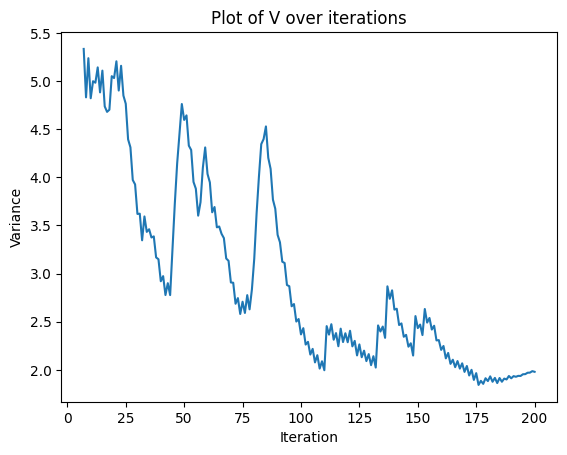

In [53]:
df_asian = pd.DataFrame(V_asian)
plt.figure()
plt.plot(df_asian.ewm(alpha=0.1).mean()[7:])
plt.title('Plot of V over iterations')
plt.xlabel('Iteration')
plt.ylabel('Variance')
plt.show()

# Barrier Option

In [3]:
def knock_out_function(y, S0, v, mu, maturity, strike, rate, barrier, d):

    d = len(y)
    k = np.arange(1, d + 1)
    y_cum = np.cumsum(y)

    s = S0*np.exp(mu*maturity + v*np.sqrt(maturity/d)*y_cum[-1])
    payoff = np.exp(-rate*maturity)*max(S0*np.sum(np.exp(mu*(k*maturity)/d + v*np.sqrt(maturity/d)*y_cum))/d - strike, 0)*(1 if s <= barrier else 0)

    return payoff

In [69]:
d = 16
T = 1
r = 0.05
S0 = 50
K = 50
B = 60
v = 0.1

params_barrier = {
    "d": d,
    "S0": S0,
    "v": v,
    "mu": r-0.5*v**2,
    "maturity": T,
    "strike": K,
    "rate": r, 
    "barrier": B
}

In [70]:
I = 100
M = 20000
mean = np.zeros(d)
cov = np.eye(d)

drift_vector_barrier = get_nu_star(knock_out_function, params_barrier)


phi_barrier = lambda y: np.exp(- drift_vector_barrier.T @ y - 0.5*drift_vector_barrier.T @ drift_vector_barrier)*knock_out_function(y + drift_vector_barrier, params_barrier['S0'], params_barrier['v'], params_barrier['mu'], params_barrier['maturity'], params_barrier['strike'], params_barrier['rate'], params_barrier['barrier'], params_barrier['d'])

In [71]:
algo_barrier = Algorithm(M,
                         I,
                         d,
                         phi_barrier,
                         mean,
                         cov)

N = 150
V_barrier, mus_barrier = algo_barrier.compute_algorithm_iteration(N)

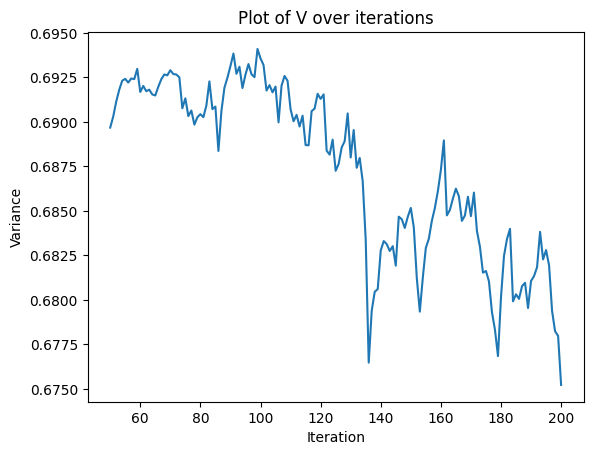

In [58]:
df_barrier = pd.DataFrame(V_barrier)
plt.figure()
plt.plot(df_barrier.ewm(alpha=0.1).mean()[50:])
plt.title('Plot of V over iterations')
plt.xlabel('Iteration')
plt.ylabel('Variance')
plt.show();

# Basket Option

In [62]:
def basket_options_function(y, S0, v, mu, sq_correl, maturity, strike, alpha, rate, d):

    y_tilde = np.dot(sq_correl, y)
    payoff = np.exp(-rate*maturity)*max(np.sum(alpha*S0*np.exp(mu*T + v*np.sqrt(maturity)*y_tilde)) - strike, 0)

    return payoff

In [60]:
d = 40
T = 1
r = 0.05
S0 = np.random.uniform(20, 80, d)
K = 45
alpha = np.ones(d)/d

c = 0.1
sigma = c*np.ones((d, d)) + (1-c)*np.eye(d)
v = np.linspace(0.1, 0.4, d)

params_basket = {
    "d": d,
    "S0": S0,
    "v": v,
    "mu": r-0.5*v**2,
    "sq_correl": np.linalg.cholesky(sigma),
    "maturity": T,
    "strike": K,
    "alpha": alpha,
    "rate": r
}

In [61]:
I = 100
M = 20000
mean = np.zeros(d)
cov = np.eye(d)

drift_vector_basket = get_nu_star(basket_options_function, params_basket)


phi_basket = lambda y: np.exp(- drift_vector_basket.T @ y - 0.5*drift_vector_basket.T @ drift_vector_basket)*basket_options_function(y + drift_vector_basket, params_basket['S0'], params_basket['v'], params_basket['mu'], params_basket['sq_correl'], params_basket['maturity'], params_basket['strike'], params_basket['alpha'], params_basket['rate'], params_basket['d'])

In [28]:
algo_basket = Algorithm(M,
                         I,
                         d,
                         phi_basket,
                         mean,
                         cov)

N = 200
V_basket, mus_basket = algo_basket.compute_algorithm_iteration(N)

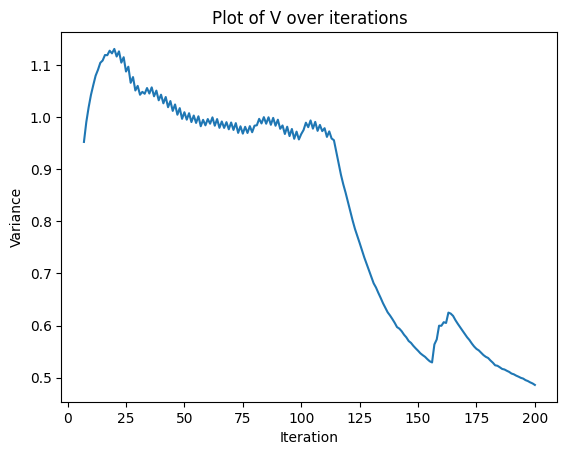

In [64]:
df_basket= pd.DataFrame(V_basket)
plt.figure()
plt.plot(df_basket.ewm(alpha=0.05).mean()[7:])
plt.title('Plot of V over iterations')
plt.xlabel('Iteration')
plt.ylabel('Variance')
plt.show();